<a href="https://colab.research.google.com/github/js0807/ai_study/blob/main/house_prices_essential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code

## import

In [76]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [77]:
df_train = pd.read_csv('/content/drive/MyDrive/data/house_prices/train.csv')

## missing data

In [78]:
df_missing = df_train.isnull().sum()
df_missing = df_missing.sort_values(ascending=False)

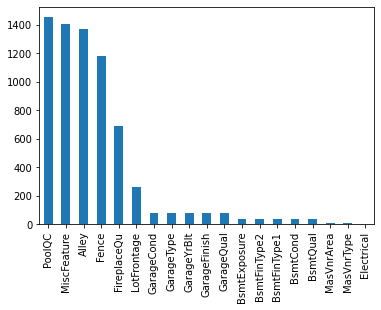

In [79]:
df_missing[df_missing > 0].plot.bar()

In [80]:
# missing data가 있는 feature 제거
df_missing = df_missing[df_missing > 0]
df_train = df_train.drop(df_missing.index.tolist(), axis=1)

In [81]:
# missing data가 있는지 재확인
df_train.isnull().sum().max()

0

## category => num

In [82]:
numeric = [f for f in df_train.columns if df_train.dtypes[f] != 'object'] # 숫자형
numeric.remove('Id')
numeric.remove('SalePrice')

categorical = [f for f in df_train.columns if df_train.dtypes[f] == 'object'] # 분류형

In [83]:
category_maps = []
def add_rank_feature (feature_name, rank_feature_name):
  df_order = pd.DataFrame()
  df_order['val'] = df_train[feature_name].unique()
  df_order.index = df_order.val

  df_order['mean_price'] = df_train[[feature_name, 'SalePrice']].groupby(feature_name).mean()['SalePrice']
  df_order['rank'] = range(1, len(df_order) + 1)
  df_order = df_order['rank'].to_dict()

  category_maps.append(df_order)

  df_train[rank_feature_name] = df_train.apply(lambda x: df_order[x[feature_name]], axis=1)

In [84]:
rank_features = []
for feature_name in categorical:
  rank_feature_name = feature_name + '_rank'

  print(feature_name, '-->', rank_feature_name)

  add_rank_feature(feature_name, rank_feature_name)
  rank_features.append(rank_feature_name)

MSZoning --> MSZoning_rank
Street --> Street_rank
LotShape --> LotShape_rank
LandContour --> LandContour_rank
Utilities --> Utilities_rank
LotConfig --> LotConfig_rank
LandSlope --> LandSlope_rank
Neighborhood --> Neighborhood_rank
Condition1 --> Condition1_rank
Condition2 --> Condition2_rank
BldgType --> BldgType_rank
HouseStyle --> HouseStyle_rank
RoofStyle --> RoofStyle_rank
RoofMatl --> RoofMatl_rank
Exterior1st --> Exterior1st_rank
Exterior2nd --> Exterior2nd_rank
ExterQual --> ExterQual_rank
ExterCond --> ExterCond_rank
Foundation --> Foundation_rank
Heating --> Heating_rank
HeatingQC --> HeatingQC_rank
CentralAir --> CentralAir_rank
KitchenQual --> KitchenQual_rank
Functional --> Functional_rank
PavedDrive --> PavedDrive_rank
SaleType --> SaleType_rank
SaleCondition --> SaleCondition_rank


In [85]:
df_processed = df_train[rank_features + numeric]

In [86]:
df_processed['SalePrice'] = df_train['SalePrice']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## data correlation

In [87]:
df_processed

,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,1,1,1,1,1,2,1,2,2,1,1,2,1,1,2,2,2,1,2,1,1,1,2,1,1,1,1,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500
2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500
3,1,1,2,1,1,3,1,3,1,1,1,1,1,1,3,3,2,1,3,1,2,1,1,1,1,1,2,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000
4,1,1,2,1,1,2,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1,1,1,1,1,1,1,18,1,1,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,1,1,60,7917,6,5,1999,2000,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,1,1,1,1,1,1,1,7,1,1,1,2,1,1,8,5,2,1,2,1,3,1,2,2,1,1,1,20,13175,6,6,1978,1988,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,1,1,1,1,1,1,1,3,1,1,1,1,1,1,7,7,3,2,6,1,1,1,1,1,1,1,1,70,9042,7,9,1941,2006,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,1,1,1,1,1,1,1,12,1,1,1,2,2,1,2,2,2,1,2,1,2,1,1,1,1,1,1,20,9717,5,6,1950,1996,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1,240,366,0,112,0,0,0,0,4,2010,142125


In [88]:
corrmat = df_processed.corr()

In [89]:
df_features = corrmat.sort_values(by=['SalePrice'])['SalePrice']

In [90]:
df_features[:-1]

Foundation_rank      -0.429678
HeatingQC_rank       -0.427649
ExterQual_rank       -0.265015
CentralAir_rank      -0.251328
PavedDrive_rank      -0.208954
HouseStyle_rank      -0.188688
Exterior2nd_rank     -0.164716
Neighborhood_rank    -0.143621
KitchenAbvGr         -0.135907
EnclosedPorch        -0.128578
ExterCond_rank       -0.121706
Exterior1st_rank     -0.120586
MSZoning_rank        -0.116047
KitchenQual_rank     -0.114746
BldgType_rank        -0.112611
Functional_rank      -0.108367
Heating_rank         -0.106673
MSSubClass           -0.084284
OverallCond          -0.077856
Condition1_rank      -0.044820
Street_rank          -0.041036
YrSold               -0.028923
LowQualFinSF         -0.025606
MiscVal              -0.021190
BsmtHalfBath         -0.016844
Utilities_rank       -0.014314
BsmtFinSF2           -0.011378
Condition2_rank      -0.004833
RoofMatl_rank         0.035820
3SsnPorch             0.044584
MoSold                0.046432
LandSlope_rank        0.051152
SaleType

## data preprocess (to fit)

In [91]:
NUM_FEATURES = len(df_features) - 1
print(NUM_FEATURES)

60


In [92]:
x = df_processed[df_features[-NUM_FEATURES-1:-1].index.tolist()]
y = df_processed['SalePrice']

In [93]:
y = np.array(y).reshape(-1, 1)

In [94]:
x.shape, y.shape

((1460, 60), (1460, 1))

### MinMaxScaling

In [95]:
x_min_max_scaler = MinMaxScaler()
x_min_max_scaler.fit(x)
scaled_X = x_min_max_scaler.transform(x)

y_min_max_scaler = MinMaxScaler()
y_min_max_scaler.fit(y)
scaled_y = y_min_max_scaler.transform(y)

### K-fold Cross Validation

In [72]:
# K-fold cross validation
K = 10
kf = KFold(n_splits=K)

## Fit (XGBoost)

In [73]:
rmses = []

for train_index, test_index in kf.split(scaled_x):
  #rint("TEST:", test_index, "TRAIN:", train_index)

  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  # training
  model = XGBRegressor(n_estimators=300)
  model = model.fit(scaled_x_train, scaled_y_train)

  # evaluation
  pred = model.predict(scaled_X_test).reshape((-1, 1))
  pred = y_min_max_scaler.inverse_transform(pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))

  print(rmse)
  print("---------------------")
  
  rmses.append(rmse)

print("average rmse:", np.mean(rmses))

[12:21:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
81147.08005523293
---------------------
[12:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
85040.24012549508
---------------------
[12:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
80850.62607902955
---------------------
[12:21:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
84063.9479080181
---------------------
[12:21:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
96203.2794239624
---------------------
[12:21:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
75298.5968671155
---------------------
[

# Kaggle Submission

In [98]:
df_test=pd.read_csv('/content/drive/MyDrive/data/house_prices/test.csv')

In [99]:
df_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,Comp

In [100]:
df_test=df_test.drop(df_missing.index.tolist(),axis=1)

In [101]:
df_test

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,1.0,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal
1,1462,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,1.0,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal
2,1463,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,2.0,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal
3,1464,60,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,602.0,0.0,324.0,926.0,GasA,Ex,Y,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,2.0,470.0,Y,360,36,0,0,0,0,0,6,2010,WD,Normal
4,1465,120,RL,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,Gd,TA,PConc,263.0,0.0,1017.0,1280.0,GasA,Ex,Y,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,2.0,506.0,Y,0,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,TA,TA,CBlock,0.0,0.0,546.0,546.0,GasA,Gd,Y,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,0.0,0.0,Y,0,0,0,0,0,0,0,6,2006,WD,Normal
1455,2916,160,RM,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,TA,TA,CBlock,252.0,0.0,294.0,546.0,GasA,TA,Y,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,1.0,286.0,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,2917,20,RL,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,TA,TA,CBlock,1224.0,0.0,0.0,1224.0,GasA,Ex,Y,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,2.0,576.0,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,2918,85,RL,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,TA,TA,PConc,337.0,0.0,575.0,912.0,GasA,TA,Y,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,0.0,0.0,Y,80,32,0,0,0,0,700,7,2006,WD,Normal


In [102]:
df_test.isnull().sum()

Id               0
MSSubClass       0
MSZoning         4
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         1
SaleCondition    0
Length: 61, dtype: int64

In [103]:
category_maps

[{'C (all)': 3, 'FV': 4, 'RH': 5, 'RL': 1, 'RM': 2},
 {'Grvl': 2, 'Pave': 1},
 {'IR1': 2, 'IR2': 3, 'IR3': 4, 'Reg': 1},
 {'Bnk': 2, 'HLS': 4, 'Low': 3, 'Lvl': 1},
 {'AllPub': 1, 'NoSeWa': 2},
 {'Corner': 3, 'CulDSac': 4, 'FR2': 2, 'FR3': 5, 'Inside': 1},
 {'Gtl': 1, 'Mod': 2, 'Sev': 3},
 {'Blmngtn': 22,
  'Blueste': 25,
  'BrDale': 23,
  'BrkSide': 9,
  'ClearCr': 20,
  'CollgCr': 1,
  'Crawfor': 3,
  'Edwards': 16,
  'Gilbert': 18,
  'IDOTRR': 14,
  'MeadowV': 15,
  'Mitchel': 5,
  'NAmes': 12,
  'NPkVill': 21,
  'NWAmes': 7,
  'NoRidge': 4,
  'NridgHt': 11,
  'OldTown': 8,
  'SWISU': 24,
  'Sawyer': 10,
  'SawyerW': 13,
  'Somerst': 6,
  'StoneBr': 19,
  'Timber': 17,
  'Veenker': 2},
 {'Artery': 4,
  'Feedr': 2,
  'Norm': 1,
  'PosA': 8,
  'PosN': 3,
  'RRAe': 5,
  'RRAn': 7,
  'RRNe': 9,
  'RRNn': 6},
 {'Artery': 2,
  'Feedr': 4,
  'Norm': 1,
  'PosA': 6,
  'PosN': 5,
  'RRAe': 8,
  'RRAn': 7,
  'RRNn': 3},
 {'1Fam': 1, '2fmCon': 2, 'Duplex': 3, 'Twnhs': 5, 'TwnhsE': 4},
 {'1.5Fin

In [104]:
categorical

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'Functional',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [105]:
def category_to_number(x, category_map, feature_name):
  if x[feature_name] in category_map:
    return category_map[x[feature_name]]
  else:
    return 0

In [106]:
for i, feature_name in enumerate(categorical):
  rank_feature_name = feature_name + '_rank'
  print(feature_name, '-->', rank_feature_name)
  
  category_map = category_maps[i]
  
  df_test[rank_feature_name] = df_test.apply(lambda x: category_to_number(x, category_map, feature_name), axis=1)

MSZoning --> MSZoning_rank
Street --> Street_rank
LotShape --> LotShape_rank
LandContour --> LandContour_rank
Utilities --> Utilities_rank
LotConfig --> LotConfig_rank
LandSlope --> LandSlope_rank
Neighborhood --> Neighborhood_rank
Condition1 --> Condition1_rank
Condition2 --> Condition2_rank
BldgType --> BldgType_rank
HouseStyle --> HouseStyle_rank
RoofStyle --> RoofStyle_rank
RoofMatl --> RoofMatl_rank
Exterior1st --> Exterior1st_rank
Exterior2nd --> Exterior2nd_rank
ExterQual --> ExterQual_rank
ExterCond --> ExterCond_rank
Foundation --> Foundation_rank
Heating --> Heating_rank
HeatingQC --> HeatingQC_rank
CentralAir --> CentralAir_rank
KitchenQual --> KitchenQual_rank
Functional --> Functional_rank
PavedDrive --> PavedDrive_rank
SaleType --> SaleType_rank
SaleCondition --> SaleCondition_rank


In [107]:
df_processed_test = df_test[rank_features + numeric]

In [108]:
df_processed_test

,MSZoning_rank,Street_rank,LotShape_rank,LandContour_rank,Utilities_rank,LotConfig_rank,LandSlope_rank,Neighborhood_rank,Condition1_rank,Condition2_rank,BldgType_rank,HouseStyle_rank,RoofStyle_rank,RoofMatl_rank,Exterior1st_rank,Exterior2nd_rank,ExterQual_rank,ExterCond_rank,Foundation_rank,Heating_rank,HeatingQC_rank,CentralAir_rank,KitchenQual_rank,Functional_rank,PavedDrive_rank,SaleType_rank,SaleCondition_rank,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,5,1,1,1,1,1,1,12,2,1,1,2,1,1,1,1,2,1,2,1,3,1,2,1,1,1,1,20,11622,5,6,1961,1961,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,6,2010
1,1,1,2,1,1,3,1,12,1,1,1,2,2,1,3,6,2,1,2,1,3,1,1,1,1,1,1,20,14267,6,6,1958,1958,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,6,2010
2,1,1,2,1,1,1,1,18,1,1,1,1,1,1,1,1,2,1,1,1,2,1,2,1,1,1,1,60,13830,5,5,1997,1998,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,3,2010
3,1,1,2,1,1,1,1,18,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,60,9978,6,6,1998,1998,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,2.0,470.0,360,36,0,0,0,0,0,6,2010
4,1,1,2,4,1,1,1,19,1,1,4,2,1,1,4,4,1,1,1,1,1,1,1,1,1,1,1,120,5005,8,5,1992,1992,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,2.0,506.0,0,82,0,0,144,0,0,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2,1,1,1,1,1,1,15,1,1,5,1,1,1,7,7,2,1,2,1,2,1,2,1,1,1,1,160,1936,4,7,1970,1970,0.0,0.0,546.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,0.0,0.0,0,0,0,0,0,0,0,6,2006
1455,2,1,1,1,1,1,1,15,1,1,4,1,1,1,7,7,2,1,2,1,3,1,2,1,1,1,2,160,1894,4,5,1970,1970,252.0,0.0,294.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,1.0,286.0,0,24,0,0,0,0,0,4,2006
1456,1,1,1,1,1,1,1,5,1,1,1,2,1,1,1,1,2,1,2,1,1,1,2,1,1,1,2,20,20000,5,7,1960,1996,1224.0,0.0,0.0,1224.0,1224,0,0,1224,1.0,0.0,1,0,4,1,7,1,2.0,576.0,474,0,0,0,0,0,0,9,2006
1457,1,1,1,1,1,1,1,5,1,1,1,5,1,1,4,3,2,1,1,1,3,1,2,1,1,1,1,85,10441,5,5,1992,1992,337.0,0.0,575.0,912.0,970,0,0,970,0.0,1.0,1,0,3,1,6,0,0.0,0.0,80,32,0,0,0,0,700,7,2006


In [109]:
df_processed_test = df_processed_test[df_features[-NUM_FEATURES-1:-1].index.tolist()]

In [110]:
df_processed_test = df_processed_test.fillna(0.0)

In [111]:
# missing data가 있는지 재확인
df_processed_test.isnull().sum().max()

0

In [112]:
df_processed_test

,Foundation_rank,HeatingQC_rank,ExterQual_rank,CentralAir_rank,PavedDrive_rank,HouseStyle_rank,Exterior2nd_rank,Neighborhood_rank,KitchenAbvGr,EnclosedPorch,ExterCond_rank,Exterior1st_rank,MSZoning_rank,KitchenQual_rank,BldgType_rank,Functional_rank,Heating_rank,MSSubClass,OverallCond,Condition1_rank,Street_rank,YrSold,LowQualFinSF,MiscVal,BsmtHalfBath,Utilities_rank,BsmtFinSF2,Condition2_rank,RoofMatl_rank,3SsnPorch,MoSold,LandSlope_rank,SaleType_rank,LandContour_rank,PoolArea,LotConfig_rank,ScreenPorch,SaleCondition_rank,RoofStyle_rank,BedroomAbvGr,BsmtUnfSF,BsmtFullBath,LotArea,LotShape_rank,HalfBath,OpenPorchSF,2ndFlrSF,WoodDeckSF,BsmtFinSF1,Fireplaces,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual
0,2,3,2,1,1,2,1,12,1,0,1,1,5,2,1,1,1,20,6,2,1,2010,0,0,0.0,1,144.0,1,1,0,6,1,1,1,0,1,120,1,1,2,270.0,0.0,11622,1,0,0,0,140,468.0,0,1961,1961,5,1,896,882.0,730.0,1.0,896,5
1,2,3,2,1,1,2,6,12,1,0,1,3,1,1,1,1,1,20,6,1,1,2010,0,12500,0.0,1,0.0,1,1,0,6,1,1,1,0,3,0,1,2,3,406.0,0.0,14267,2,1,36,0,393,923.0,0,1958,1958,6,1,1329,1329.0,312.0,1.0,1329,6
2,1,2,2,1,1,1,1,18,1,0,1,1,1,2,1,1,1,60,5,1,1,2010,0,0,0.0,1,0.0,1,1,0,3,1,1,1,0,1,0,1,1,3,137.0,0.0,13830,2,1,34,701,212,791.0,1,1998,1997,6,2,928,928.0,482.0,2.0,1629,5
3,1,1,2,1,1,1,1,18,1,0,1,1,1,1,1,1,1,60,6,1,1,2010,0,0,0.0,1,0.0,1,1,0,6,1,1,1,0,1,0,1,1,3,324.0,0.0,9978,2,1,36,678,360,602.0,1,1998,1998,7,2,926,926.0,470.0,2.0,1604,6
4,1,1,1,1,1,2,4,19,1,0,1,4,1,1,4,1,1,120,5,1,1,2010,0,0,0.0,1,0.0,1,1,0,1,1,1,4,0,1,144,1,1,2,1017.0,0.0,5005,2,0,82,0,0,263.0,0,1992,1992,5,2,1280,1280.0,506.0,2.0,1280,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2,2,2,1,1,1,7,15,1,0,1,7,2,2,5,1,1,160,7,1,1,2006,0,0,0.0,1,0.0,1,1,0,6,1,1,1,0,1,0,1,1,3,546.0,0.0,1936,1,1,0,546,0,0.0,0,1970,1970,5,1,546,546.0,0.0,0.0,1092,4
1455,2,3,2,1,1,1,7,15,1,0,1,7,2,2,4,1,1,160,5,1,1,2006,0,0,0.0,1,0.0,1,1,0,4,1,1,1,0,1,0,2,1,3,294.0,0.0,1894,1,1,24,546,0,252.0,0,1970,1970,6,1,546,546.0,286.0,1.0,1092,4
1456,2,1,2,1,1,2,1,5,1,0,1,1,1,2,1,1,1,20,7,1,1,2006,0,0,0.0,1,0.0,1,1,0,9,1,1,1,0,1,0,2,1,4,0.0,1.0,20000,1,0,0,0,474,1224.0,1,1996,1960,7,1,1224,1224.0,576.0,2.0,1224,5
1457,1,3,2,1,1,5,3,5,1,0,1,4,1,2,1,1,1,85,5,1,1,2006,0,700,1.0,1,0.0,1,1,0,7,1,1,1,0,1,0,1,1,3,575.0,0.0,10441,1,0,32,0,80,337.0,0,1992,1992,6,1,970,912.0,0.0,0.0,970,5


In [113]:
scaled_X_test = x_min_max_scaler.transform(df_processed_test)

In [114]:
scaled_X_test

array([[0.2       , 0.5       , 0.33333333, ..., 0.25      , 0.10587792,
        0.44444444],
       [0.2       , 0.5       , 0.33333333, ..., 0.25      , 0.1874529 ,
        0.55555556],
       [0.        , 0.25      , 0.33333333, ..., 0.5       , 0.24397136,
        0.44444444],
       ...,
       [0.2       , 0.        , 0.33333333, ..., 0.5       , 0.16767144,
        0.44444444],
       [0.        , 0.5       , 0.33333333, ..., 0.        , 0.11981914,
        0.44444444],
       [0.        , 0.        , 0.33333333, ..., 0.75      , 0.31386586,
        0.66666667]])

In [ ]:
# predict
pred = model.predict(scaled_X_test).reshape((-1, 1))
pred = y_min_max_scaler.inverse_transform(pred)

In [ ]:
df_submission=pd.DataFrame(columns=['Id','SalePrice'])

In [ ]:
df_submission['Id']=np.arange(1461,1461+1459)

In [ ]:
df_submission['SalePrice'] = pred #XGBoost Prediction 값

In [ ]:
df_submission

,Id,SalePrice
0,1461,118003.882812
1,1462,157929.781250
2,1463,181756.062500
3,1464,184412.593750
4,1465,183726.125000
...,...,...
1454,2915,77995.093750
1455,2916,83047.640625
1456,2917,180693.609375
1457,2918,124154.039062


In [ ]:
df_submission.to_csv('submission_xgboost.csv',index=False)

# Model Stacking

## 개념
**단계**
*   k-fold validation처럼 train set을 여러개로 나눈다. 
*   후보 모델에 각각 다 넣어서 학습 (ex : RandomForest, XGBoost, Neural Networks)
*   학습되지 않은 값들을 종합하여 prediction함.
*   나눠진 test set들의 Prediction들을 모아 이걸 모델별로 또 수집함.
*   이 결과값들을 input으로 하여 또 다른 모델에 넣어 또 prediction을 하여 정확성을 높인다.
*   모델 별로 가중치를 둔다.


## 구현

In [46]:
level_1_preds = [] # (146, 2) x 10

for train_index, test_index in kf.split(scaled_X):
  scaled_X_train, scaled_X_test = scaled_X[train_index], scaled_X[test_index]
  scaled_y_train, scaled_y_test = scaled_y[train_index], scaled_y[test_index]
  y_test = y[test_index]

  # Train
  # 1. XGBoost
  xgb_model = XGBRegressor(n_estimators=300)
  xgb_model = xgb_model.fit(scaled_X_train, scaled_y_train)

  # 2. Random Forest
  rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
  rf_model = rf_model.fit(scaled_X_train, scaled_y_train)

  # 3. MLP

  # Predict
  # 1. XGBoost
  xgb_pred = xgb_model.predict(scaled_X_test).reshape((-1, 1))
  print(xgb_pred.shape) # --> (146, 1)

  # 2. Random Forest
  rf_pred = rf_model.predict(scaled_X_test).reshape((-1, 1))
  print(rf_pred.shape)  # --> (146, 1)

  # Concatenate --> (146, 2)
  pred = np.concatenate([xgb_pred, rf_pred], axis=1)
  print(pred.shape) # --> (146, 2)

  print("---------------------")

  level_1_preds.append(pred)

[12:10:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
---------------------
[12:10:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
---------------------
[12:10:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
---------------------
[12:10:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
---------------------
[12:10:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
---------------------
[12:10:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
---------------------
[12:11:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
---------------------
[12:11:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
---------------------
[12:11:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
---------------------
[12:11:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


(146, 1)
(146, 1)
(146, 2)
---------------------


In [47]:
level_1_preds = np.concatenate(level_1_preds, axis=0)

In [48]:
level_1_preds.shape

(1460, 2)

In [49]:
level_2_model = XGBRegressor()
level_2_model = level_2_model.fit(level_1_preds, scaled_y)

[12:18:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## submission

In [115]:
xgb_pred = xgb_model.predict(scaled_X_test).reshape((-1, 1))
rf_pred = rf_model.predict(scaled_X_test).reshape((-1, 1))

In [116]:
xgb_pred.shape, rf_pred.shape

((1459, 1), (1459, 1))

In [117]:
level_2_input = np.concatenate([xgb_pred, rf_pred], axis=1)

In [118]:
level_2_input.shape

(1459, 2)

In [119]:
level_2_input[:5]

array([[0.11540604, 0.1257234 ],
       [0.17085096, 0.16423625],
       [0.20393842, 0.19357627],
       [0.20762753, 0.20376496],
       [0.20667425, 0.23646564]])

In [120]:
pred = level_2_model.predict(level_2_input).reshape((-1,1))
pred = y_min_max_scaler.inverse_transform(pred)

In [121]:
pred[:5]

array([[121221.4 ],
       [155675.55],
       [176211.64],
       [185451.78],
       [186447.52]], dtype=float32)

In [122]:
df_submission = pd.DataFrame(columns=['Id', 'SalePrice'])
df_submission['Id'] = np.arange(1461, 2919 + 1)
df_submission['SalePrice'] = pred

In [123]:
df_submission

,Id,SalePrice
0,1461,121221.398438
1,1462,155675.546875
2,1463,176211.640625
3,1464,185451.781250
4,1465,186447.515625
...,...,...
1454,2915,70974.109375
1455,2916,71989.031250
1456,2917,178874.265625
1457,2918,122262.710938


In [124]:
df_submission.to_csv('submission_stack_1.csv',index=False)

# Model Quantization

## 개념
**모델 경량화**
* inference time (prediction 하는데 걸리는 시간)
* 실제 프로젝트에서는 2개의 기준(accuracy, inference time)을 사용함.
* 왜냐하면 아무리 정확도가 좋아도 inference time 때문에 사용하지 못하는 model이 생길 수 있음.
* 모델의 복잡성과 inference time은 비례한다.
* 따라서 모델의 아키텍쳐를 건드리지 말고 경량화하여 시간을 줄여보자!

**방식**
* model(weight/operation)의 datatype을 float32에서 int8로 변경!
* 기존 모델과 거의 비슷한 accuracy를 갖도록 하게 하는 것
* 학습이 이미 완료된 모델의 datatype 변환
  * 레이어 별로 진행됨.
  * 최대, 최소값을 이용하여 변환
  * 큰 모델에서 accuracy drop 그렇게 많이 안됨.
  * 모델이 작으면 accuracy drop 크게 발생
    * outlier weigth value의 영향 큼
* 학습 진행중에 datatype 변환 (QAT)
  * weight를 학습하는 동시에 진행
  * 모델 안에 두 타입 레이어가 공존 -> int8 추출
  * 위 방식보다 더 높은 accuracy!




## 구현

In [125]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 211 kB 8.2 MB/s 


In [126]:
import tensorflow_model_optimization as tfmot

In [128]:
  model = keras.Sequential(
      [
          keras.Input(shape=scaled_X_train.shape[-1]),
          layers.Dense(96, activation='relu'),
          layers.Dense(48, activation='relu'),
          layers.Dense(1)
      ]
  )

In [129]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
opt = keras.optimizers.Adam(learning_rate=0.005)
q_aware_model.compile(optimizer=opt,
                      loss="mse")

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 60)                3         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 96)                5861      
_________________________________________________________________
quant_dense_1 (QuantizeWrapp (None, 48)                4661      
_________________________________________________________________
quant_dense_2 (QuantizeWrapp (None, 1)                 54        
Total params: 10,579
Trainable params: 10,561
Non-trainable params: 18
_________________________________________________________________


In [130]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
q_aware_model.fit(scaled_X_train, scaled_y_train, 
                  batch_size=2, epochs=150, 
                  callbacks=[early_stopping_callback], validation_split=0.05, verbose='auto')

Epoch 1/150
624/624 [==============================] - 2s 2ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 2/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0113
Epoch 3/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0059
Epoch 4/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 5/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 6/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 7/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 8/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 9/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0041
Epoch 10/150
624/624 [==============================] - 1s 2ms/step - loss: 0.0066 - val_lo

### Convert into quantized model(int8)

In [131]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpluph13sz/assets


INFO:tensorflow:Assets written to: /tmp/tmpluph13sz/assets


In [132]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

### Inference quantized model

In [133]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [134]:
scaled_X.shape

(1460, 60)

In [135]:
float32_X = scaled_X.astype(np.float32)

In [136]:
float32_X.shape

(1460, 60)

In [137]:
interpreter.set_tensor(input_index, [float32_X[0]])

In [138]:
# Run inference.
interpreter.invoke()

In [139]:
output = interpreter.tensor(output_index)

In [140]:
output()

array([[0.20993486]], dtype=float32)

In [141]:
y_min_max_scaler.inverse_transform(output())

array([[186074.1]], dtype=float32)

### Check Model Size
Size 비교를 통해 quantized 됬는지 확인.

In [142]:
import os, tempfile

In [143]:
# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(quantized_tflite_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

INFO:tensorflow:Assets written to: /tmp/tmp9yoac893/assets


INFO:tensorflow:Assets written to: /tmp/tmp9yoac893/assets


Float model in Mb: 0.040920257568359375
Quantized model in Mb: 0.013153076171875
